# loki thor 


In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'passport2')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
# CSV_GITCOIN_GRANTS = 'vote_coefficients_0x274554EB289004e15A7679123901B7F070dDa0fa_1.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY2']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
# PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
# df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
# df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())


In [2]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum')

In [3]:
array_unique_address = df_tx.EOA.unique()
array_unique_address = np.char.lower(array_unique_address.astype(str))

In [4]:
len(array_unique_address)

5992

In [5]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [6]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address)))

use matching address because some addresses are not in the extracted data set

In [7]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x000000000f709dfe4346b80009b8a5197f79aa14
1,0x00043607fa39c35d613fa48a17c7ed1afd57bbf6


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [8]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
# df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [9]:
print(f'Number of addresses: {len(df_matching_address)}')

Number of addresses: 5992


In [10]:
df_matching_address.sum()

address                  0x000000000f709dfe4346b80009b8a5197f79aa140x00...
seed_same_naive                                                       3732
seed_same                                                             3859
seed_suspicious                                                        245
less_5_tx                                                              204
interacted_other_ctbt                                                 1123
dtype: object

### Computing the new dex interaction score
It was investigated in another notebook 

In [11]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [12]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [13]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [14]:
tx_analyser.set_group_by_sorted_EOA()

In [15]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [16]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.47363150867823767

In [17]:
label_query = '''
SELECT DISTINCT(LABEL_SUBTYPE)
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_labels = flipside_api.execute_query(label_query)

In [18]:
df_distinct_labels.label_subtype.unique()

array(['router', 'strategy', 'foundation', 'marketplace',
       'donation_address', 'mining_pool', 'fee_wallet', 'chadmin',
       'governance', 'cold_wallet', 'nf_token_contract',
       'token_distribution', 'nf_position_manager', 'multisig',
       'airdrop_contract', 'pool', 'deposit_wallet', 'staking_contract',
       'bridge', 'token_contract', 'mint_burn', 'mint_contract',
       'contract_deployer', 'reserve', 'escrow', 'vault', 'oracle',
       'treasury', 'token_sale', 'swap_router', 'voting',
       'aggregator_contract', 'general_contract', 'hot_wallet',
       'distributor_cex', 'swap_contract', 'toxic', 'dao', 'rewards'],
      dtype=object)

From these tags lets flag any address that have interacted with a toxic wallet

In [33]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [34]:
df_toxic.shape

(4857, 6)

In [35]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [36]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 2%


In [37]:
tag_query = '''
SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_tags = flipside_api.execute_query(tag_query)

QUERY_RUN_TIMEOUT_ERROR: your query has timed out after 325.0 minutes.

SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;


In [38]:
df_distinct_tags.tag_type.values

AttributeError: 'DataFrame' object has no attribute 'tag_type'

I found the tag_name "airdrop master" could be interesting 

In [25]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [26]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 20%


In [27]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 8%


In [28]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [29]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 1%


In [30]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 1%


In [31]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,count_interaction_with_pool,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,5992.000000,5992.000000,5992.000000,5992.000000
mean,6.086949,1.920227,0.060748,0.052069
std,35.291943,10.253683,0.853077,0.788601
min,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000
90%,10.000000,3.000000,0.000000,0.000000
max,1228.000000,309.000000,39.000000,39.000000


In [39]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [40]:
boolean_features = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [41]:
df_matching_address[boolean_features].sum() 

seed_suspicious               245
has_interaction_toxic         146
has_no_pool_interaction      5035
has_interaction_airdrop_m    1225
has_interaction_tornado        93
has_interaction_disperse       83
is_airdrop_master             528
interacted_other_ctbt        1123
dtype: int64

In [42]:
len(df_matching_address)

5992

### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_interaction_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [43]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [44]:
interaction_bool = ['has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [45]:
df_matching_address[interaction_bool].sum()

has_interaction_toxic         146
has_interaction_airdrop_m    1225
has_interaction_disperse       83
is_airdrop_master             528
seed_suspicious               245
interact_less_5tx               2
dtype: int64

In [46]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_interaction_toxic,1.000000,0.066926,0.050459,0.071542,0.007732,0.0
has_interaction_airdrop_m,0.066926,1.000000,0.038095,0.327025,0.011700,0.0
has_interaction_disperse,0.050459,0.038095,1.000000,0.033841,0.003058,0.0
is_airdrop_master,0.071542,0.327025,0.033841,1.000000,0.010458,0.0
seed_suspicious,0.007732,0.011700,0.003058,0.010458,1.000000,0.0
interact_less_5tx,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


<Axes: >

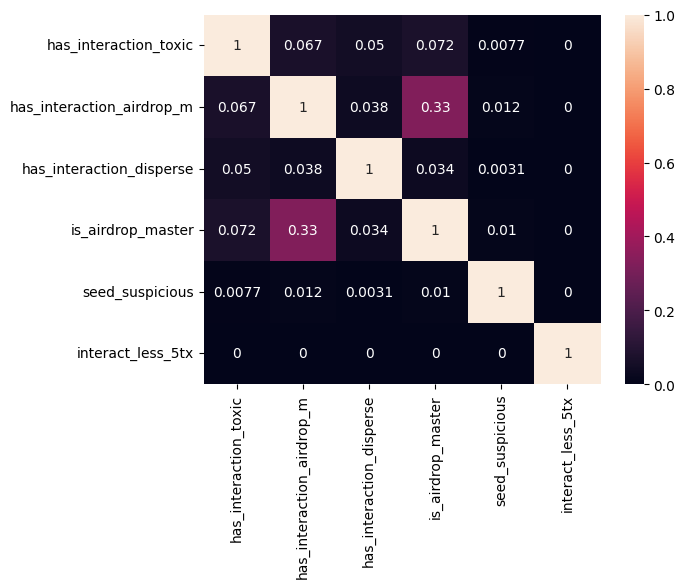

In [47]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [48]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 1637


In [49]:
boolean_to_keep = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [50]:
df_matching_address[boolean_to_keep].sum()

seed_suspicious               245
has_interaction_toxic         146
has_no_pool_interaction      5035
has_interaction_tornado        93
has_interaction_disperse       83
is_airdrop_master             528
has_interaction_airdrop_m    1225
interacted_other_ctbt        1123
interact_less_5tx               2
flagged                      1637
dtype: int64

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_12636\2348526555.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(5992, 19) matching address merge
(5992, 22) votes merge


<Axes: >

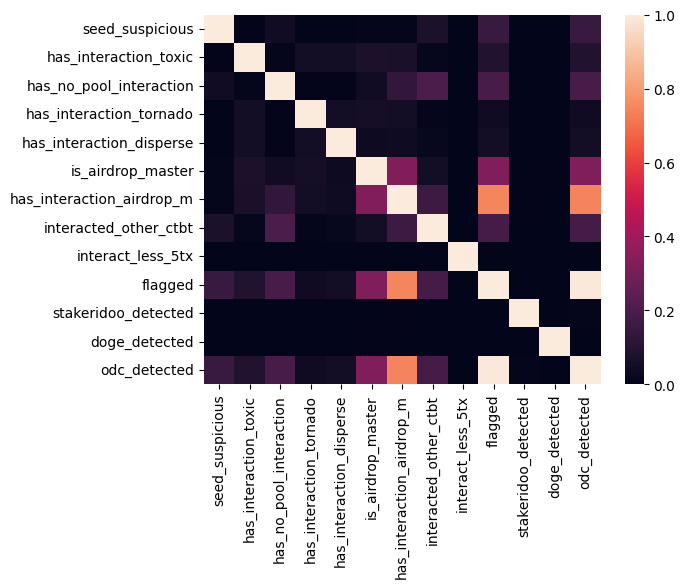

In [51]:
# Adding Stakeriddo and ddoge flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{df_matching_address.shape} matching address merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = df_matching_address.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='address', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

In [52]:
df_merge[boolean_jaccard].sum(axis=0)

seed_suspicious               245
has_interaction_toxic         146
has_no_pool_interaction      5035
has_interaction_tornado        93
has_interaction_disperse       83
is_airdrop_master             528
has_interaction_airdrop_m    1225
interacted_other_ctbt        1123
interact_less_5tx               2
flagged                      1637
stakeridoo_detected            15
doge_detected                   5
odc_detected                 1648
dtype: int64

In [53]:
# Set path to data folder
PATH_TO_LOKI = os.path.join(DATA_DIR, "thor_loki.csv")

# Load data
df_loki = pd.read_csv(PATH_TO_LOKI)
print(f'{df_loki.shape} loki')

(35127, 9) loki


In [54]:
df_loki.dropna(subset=['Wallet Address'], inplace=True)
print(f'{df_loki.shape} loki dropna')

(21189, 9) loki dropna


In [55]:
df_loki.dropna(subset=['Thor/Loki Indicator'], inplace=True)
print(f'{df_loki.shape} loki dropna thor/loki indicator')

(4433, 9) loki dropna thor/loki indicator


In [56]:
df_merge.shape

(5992, 23)

In [57]:
df_loki.drop_duplicates(subset=['Wallet Address'], inplace=True)
print(f'{df_loki.shape} loki drop duplicates')

(4431, 9) loki drop duplicates


In [58]:
intersect = np.intersect1d(df_merge.address.unique(), df_loki['Wallet Address'].unique())
print(f'Number of addresses in loki: {len(intersect)}')

Number of addresses in loki: 4206


In [59]:
merge_loki = df_merge.merge(df_loki, left_on='address', right_on='Wallet Address', how='left')
merge_loki.dropna(subset=['Thor/Loki Indicator'], inplace=True)
print(f'{merge_loki.shape} merge loki')

(4206, 32) merge loki


In [60]:
merge_loki['loki'] = merge_loki['Thor/Loki Indicator'] == 'loki'

<Axes: >

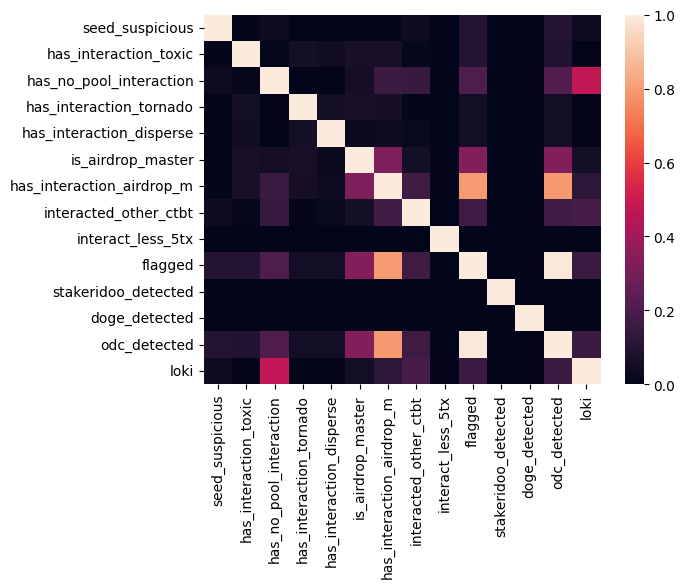

In [61]:
boolean_jaccard_2 = boolean_jaccard + ['loki']
jaccard_similarity_3 = jaccard_similarity_matrix(merge_loki[boolean_jaccard_2])
sns.heatmap(jaccard_similarity_3)


In [62]:
merge_loki[boolean_jaccard_2].sum(axis=0)

seed_suspicious               119
has_interaction_toxic         118
has_no_pool_interaction      3459
has_interaction_tornado        82
has_interaction_disperse       61
is_airdrop_master             419
has_interaction_airdrop_m     997
interacted_other_ctbt         599
interact_less_5tx               2
flagged                      1255
stakeridoo_detected             8
doge_detected                   3
odc_detected                 1262
loki                         1836
dtype: int64

In [64]:
merge_loki[merge_loki['loki'] == True][boolean_jaccard_2].sum(axis=0)

seed_suspicious                70
has_interaction_toxic          15
has_no_pool_interaction      1700
has_interaction_tornado         8
has_interaction_disperse       10
is_airdrop_master             111
has_interaction_airdrop_m     306
interacted_other_ctbt         385
interact_less_5tx               2
flagged                       413
stakeridoo_detected             3
doge_detected                   2
odc_detected                  416
loki                         1836
dtype: int64

In [82]:
path_to_full_feature = os.path.join(current_dir.parent, 'output_gitcoin', 'loki-thor-analysis', 'merge_loki.csv')
merge_loki.to_csv(path_to_full_feature, index=False)

<Axes: >

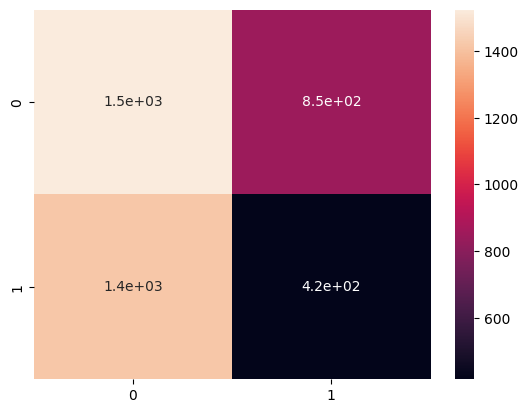

In [65]:
# confusion matrix loki vs odc_detected
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(merge_loki['loki'], merge_loki['odc_detected'])
# plot confusion matrix
sns.heatmap(cm, annot=True) # font size

In [66]:
# compute precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(merge_loki['loki'], merge_loki['odc_detected'])
recall_score(merge_loki['loki'], merge_loki['odc_detected'])
print(f'Precision: {precision_score(merge_loki["loki"], merge_loki["odc_detected"])}')
print(f'Recall: {recall_score(merge_loki["loki"], merge_loki["odc_detected"])}')

Precision: 0.329635499207607
Recall: 0.22657952069716775


In [67]:
stats = []
for flag in boolean_jaccard_2:
    stats.append(merge_loki[merge_loki[flag] == True][boolean_jaccard_2].sum(axis=0))
stats = pd.concat(stats, axis=1)
stats.columns = boolean_jaccard_2

In [68]:
stats

,seed_suspicious,has_interaction_toxic,has_no_pool_interaction,has_interaction_tornado,has_interaction_disperse,is_airdrop_master,has_interaction_airdrop_m,interacted_other_ctbt,interact_less_5tx,flagged,stakeridoo_detected,doge_detected,odc_detected,loki
seed_suspicious,119,2,113,0,1,3,10,25,0,119,0,0,119,70
has_interaction_toxic,2,118,52,10,8,33,68,9,0,118,0,0,118,15
has_no_pool_interaction,113,52,3459,22,27,208,597,529,2,806,8,1,813,1700
has_interaction_tornado,0,10,22,82,7,30,56,6,0,62,0,0,62,8
has_interaction_disperse,1,8,27,7,61,13,34,13,0,61,0,0,61,10
is_airdrop_master,3,33,208,30,13,419,343,50,0,419,0,3,419,111
has_interaction_airdrop_m,10,68,597,56,34,343,997,231,0,997,1,2,997,306
interacted_other_ctbt,25,9,529,6,13,50,231,599,2,265,1,2,266,385
interact_less_5tx,0,0,2,0,0,0,0,2,2,2,0,0,2,2
flagged,119,118,806,62,61,419,997,265,2,1255,1,3,1255,413


In [69]:
# divide each column by the max of the column
stats = stats.div(stats.max(axis=0), axis=1)
stats.applymap(lambda x: 100*round(x, 2))

,seed_suspicious,has_interaction_toxic,has_no_pool_interaction,has_interaction_tornado,has_interaction_disperse,is_airdrop_master,has_interaction_airdrop_m,interacted_other_ctbt,interact_less_5tx,flagged,stakeridoo_detected,doge_detected,odc_detected,loki
seed_suspicious,100.0,2.0,3.0,0.0,2.0,1.0,1.0,4.0,0.0,9.0,0.0,0.0,9.0,4.0
has_interaction_toxic,2.0,100.0,2.0,12.0,13.0,8.0,7.0,2.0,0.0,9.0,0.0,0.0,9.0,1.0
has_no_pool_interaction,95.0,44.0,100.0,27.0,44.0,50.0,60.0,88.0,100.0,64.0,100.0,33.0,64.0,93.0
has_interaction_tornado,0.0,8.0,1.0,100.0,11.0,7.0,6.0,1.0,0.0,5.0,0.0,0.0,5.0,0.0
has_interaction_disperse,1.0,7.0,1.0,9.0,100.0,3.0,3.0,2.0,0.0,5.0,0.0,0.0,5.0,1.0
is_airdrop_master,3.0,28.0,6.0,37.0,21.0,100.0,34.0,8.0,0.0,33.0,0.0,100.0,33.0,6.0
has_interaction_airdrop_m,8.0,58.0,17.0,68.0,56.0,82.0,100.0,39.0,0.0,79.0,12.0,67.0,79.0,17.0
interacted_other_ctbt,21.0,8.0,15.0,7.0,21.0,12.0,23.0,100.0,100.0,21.0,12.0,67.0,21.0,21.0
interact_less_5tx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
flagged,100.0,100.0,23.0,76.0,100.0,100.0,100.0,44.0,100.0,100.0,12.0,100.0,99.0,22.0


<Axes: >

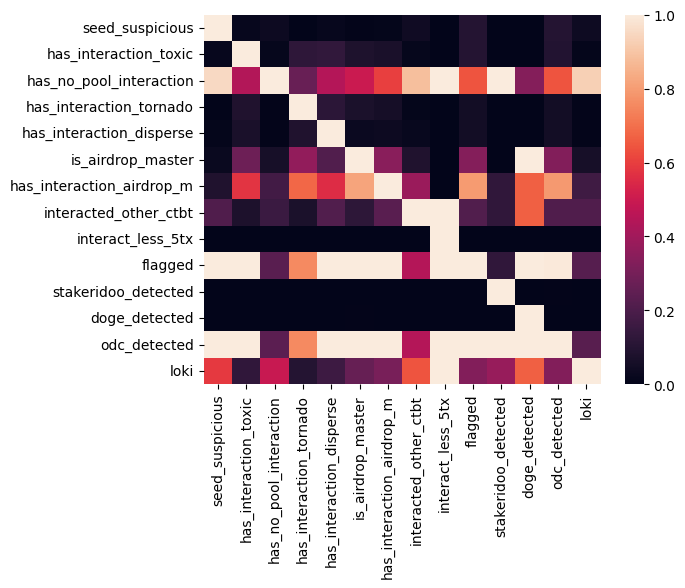

In [70]:
sns.heatmap(stats)